In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.decomposition import PCA


In [12]:
G = nx.karate_club_graph()
print(f"The network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

The network has 34 nodes and 78 edges.


In [13]:
G.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

In [14]:
y = [1 if G.nodes[v]['club'] == 'Officer' else 0 for v in G]
y = torch.tensor(y)


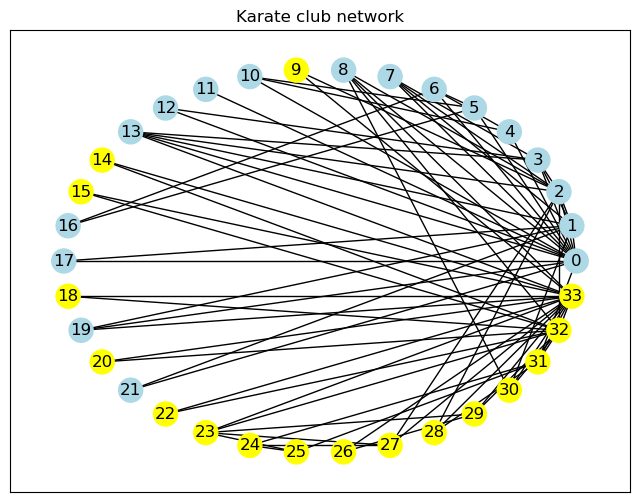

In [15]:
plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
node_color = ['yellow' if G.nodes[v]['club'] == 'Officer' else 'lightblue' for v in G]
nx.draw_networkx(G, pos=pos, node_color=node_color, with_labels=True)
plt.title('Karate club network')
plt.show()

In [16]:
# Adjacency matrix
A = nx.adjacency_matrix(G).todense()
A = torch.tensor(A, dtype=torch.float)
X = np.eye(A.shape[0])
X = torch.from_numpy(X).float()

In [17]:
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i, j] >0:
            A[i, j] = 1 

In [23]:
class GCN_Layer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN_Layer, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        
    def gcn_layer(self, A, D):
        A_hat1 = A + torch.eye(A.shape[0], device=A.device)
        return torch.matmul(torch.matmul(D, A_hat1), D)
    
    def forward(self, A, X):
        D = torch.diag(torch.sum(A+torch.eye(A.shape[0], device=A.device), dim=0) ** (-0.5))
        A_hat = self.gcn_layer(A, D)
        return F.relu(torch.matmul(A_hat, self.linear(X)))
    

class GraphSAGEConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphSAGEConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight1 = nn.Linear(in_features=in_features, out_features=out_features)
        self.weight2 = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, A, x):
        aggregated = torch.matmul(A, x)
        x1 = self.weight1(x)
        x2 = self.weight2(aggregated)
        x = x1 + x2
        x = F.relu(x)
        return x

import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, num_heads=1, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_heads = num_heads
        self.alpha = alpha

        self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.a = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W.data)
        nn.init.xavier_uniform_(self.a.data)

    def forward(self, adj, x):
        h = torch.matmul(x, self.W)  # Linear transformation

        N = h.size(0)  # Number of nodes
        heads_output = []

        for _ in range(self.num_heads):
            a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1)
            e = self.leaky_relu(torch.matmul(a_input, self.a).squeeze())

            # Apply masked attention to consider only neighboring nodes
            e = e.view(N, N)
            e = torch.where(adj > 0, e, torch.tensor(float('-inf')))  # Masking
            alpha = F.softmax(e, dim=1)

            # Attention-based aggregation
            h_prime = torch.matmul(alpha, h)
            heads_output.append(h_prime)

        # Concatenate or average the heads' output
        output = torch.mean(torch.stack(heads_output), dim=0)

        return output

    def leaky_relu(self, input):
        return F.leaky_relu(input, negative_slope=self.alpha)

class GNN(nn.Module):
    def __init__(self, in_features=34, hidden_dim=64, classes=2):
        super(GNN, self).__init__()
        self.conv1 = GCN_Layer(in_features, hidden_dim)
        self.conv2 = GCN_Layer(hidden_dim, hidden_dim)
        self.conv3 = GCN_Layer(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, classes)

        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.zeros_(self.fc.bias)
    def forward(self, A, x):
        x = self.conv1(A, x)
        x = F.relu(x)
        x = self.conv2(A, x)
        x = F.relu(x)
        x = self.conv3(A, x)
        h = h = x.detach().clone()
        x = self.fc(x)
        return F.softmax(x, dim=1), h


In [24]:
embedding = []

In [25]:
in_features = X.shape[1]  # Number of input features
hidden_dim = 64  # Number of hidden features
classes = 2  # Number of classes
gcn_layer = GNN(in_features, hidden_dim, classes)
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = torch.optim.Adam(gcn_layer.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass
    output,h = gcn_layer(A, X)

    embedding.append(h.detach().clone().numpy())

    # Compute the loss
    loss = criterion(output, y)  # Assume y contains the ground truth class labels
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute the accuracy
    predicted_labels = output.argmax(dim=1)
    accuracy = (predicted_labels == y).float().mean()

    # Print the loss and accuracy for monitoring
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')


Epoch [1/100], Loss: 0.6931, Accuracy: 0.5000
Epoch [2/100], Loss: 0.6907, Accuracy: 0.5000
Epoch [3/100], Loss: 0.6869, Accuracy: 0.5000
Epoch [4/100], Loss: 0.6798, Accuracy: 0.6471
Epoch [5/100], Loss: 0.6667, Accuracy: 0.9706
Epoch [6/100], Loss: 0.6471, Accuracy: 0.9706
Epoch [7/100], Loss: 0.6191, Accuracy: 0.9706
Epoch [8/100], Loss: 0.5814, Accuracy: 0.9706
Epoch [9/100], Loss: 0.5362, Accuracy: 0.9706
Epoch [10/100], Loss: 0.4868, Accuracy: 0.9706
Epoch [11/100], Loss: 0.4383, Accuracy: 0.9706
Epoch [12/100], Loss: 0.3968, Accuracy: 0.9706
Epoch [13/100], Loss: 0.3669, Accuracy: 0.9706
Epoch [14/100], Loss: 0.3490, Accuracy: 0.9706
Epoch [15/100], Loss: 0.3395, Accuracy: 0.9706
Epoch [16/100], Loss: 0.3339, Accuracy: 0.9706
Epoch [17/100], Loss: 0.3307, Accuracy: 1.0000
Epoch [18/100], Loss: 0.3276, Accuracy: 1.0000
Epoch [19/100], Loss: 0.3260, Accuracy: 1.0000
Epoch [20/100], Loss: 0.3240, Accuracy: 1.0000
Epoch [21/100], Loss: 0.3222, Accuracy: 1.0000
Epoch [22/100], Loss: 

In [26]:
output,h = gcn_layer(A, X)
predicted_labels = output.argmax(dim=1)

In [27]:
fig = plt.figure(dpi=150)
ax = fig.subplots()

def draw_embeddings(i):
    output = embedding[i]

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(output)

    feature_representations = {node: embeddings_2d[node] for node in G.nodes()}

    ax.cla()
    ax.axis('off')
    ax.set_title('Karate club network node embeddings for epoch: %d' % i)    
    nx.draw_networkx(G, pos=feature_representations, node_color=node_color,
                     with_labels=True, node_size=300, ax=ax)
    plt.close()

anim = animation.FuncAnimation(fig, draw_embeddings, frames=len(embedding), interval=200)
HTML(anim.to_html5_video())


In [38]:
# Convert the graph to a pandas DataFrame
edge_list = nx.to_pandas_edgelist(G)

# Extract the source and target columns
source = edge_list['source'].to_numpy()
target = edge_list['target'].to_numpy()

# Create the edge index tensor
edge_index = torch.tensor([source, target], dtype=torch.long)

In [39]:
embedding1 = []

In [40]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import DenseGraphConv
from torch_geometric.nn import Linear
import torch.nn.init as init

class GNN1(nn.Module):
    def __init__(self, in_features=34, hidden_dim=64, classes=2):
        super(GNN1, self).__init__()
        self.conv1 = DenseGraphConv(in_channels=in_features, out_channels=hidden_dim)
        self.conv2 = DenseGraphConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = DenseGraphConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.fc = Linear(hidden_dim, classes)
        
        # Xavier initialization for Linear layer
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.zeros_(self.fc.bias)

    def forward(self, x, A):
        x = self.conv1(x, A)
        x = F.relu(x)
        x = self.conv2(x, A)
        x = F.relu(x)
        x = self.conv3(x, A)
        x = F.relu(x)
        h = x.detach().clone()
        x = self.fc(x)
        return F.softmax(x, dim=1), h

in_features = X.shape[1]
hidden_dim = 64
classes = 2
gcn_layer1 = GNN1(in_features, hidden_dim, classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_layer1.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    output,h1= gcn_layer1(X, A)
    print(output.squeeze().shape)
    embedding1.append(h1.detach().clone().numpy())
    loss = criterion(output.squeeze(), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    predicted_labels = output.argmax(dim=1)
    # accuracy = (predicted_labels == y).float().mean()
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')


torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])
torch.Size([34, 2])


In [41]:
print(embedding1[0].shape)

(1, 34, 64)


In [42]:
fig = plt.figure(dpi=150)
ax = fig.subplots()

def draw_embeddings(i):
    output = embedding1[i].squeeze()

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(output)

    feature_representations = {node: embeddings_2d[node] for node in G.nodes()}

    ax.cla()
    ax.axis('off')
    ax.set_title('Karate club network node embeddings for epoch: %d' % i)    
    nx.draw_networkx(G, pos=feature_representations, node_color=node_color,
                     with_labels=True, node_size=300, ax=ax)
    plt.close()

anim = animation.FuncAnimation(fig, draw_embeddings, frames=len(embedding1), interval=200)
HTML(anim.to_html5_video())


In [47]:
embedding[-1]

array([[0.        , 0.16207245, 0.        , ..., 0.22943522, 0.        ,
        0.02079341],
       [0.        , 0.1173506 , 0.        , ..., 0.16504645, 0.        ,
        0.01437089],
       [0.        , 0.1214115 , 0.        , ..., 0.16019382, 0.        ,
        0.01017076],
       ...,
       [0.        , 0.09692225, 0.        , ..., 0.11270113, 0.        ,
        0.        ],
       [0.        , 0.1293189 , 0.        , ..., 0.19246669, 0.        ,
        0.01861216],
       [0.        , 0.15748459, 0.        , ..., 0.24162737, 0.        ,
        0.02855072]], dtype=float32)

In [48]:
embedding1[-1].squeeze()

array([[ 0.        ,  0.21088916,  0.        , ...,  0.        ,
         0.        , 41.44492   ],
       [ 0.        ,  0.45193157,  0.        , ...,  0.        ,
         0.        , 28.360615  ],
       [ 0.        ,  0.        ,  0.        , ...,  5.8079615 ,
         0.        , 28.8829    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 17.761679  ,
         0.        , 13.640668  ],
       [ 0.        ,  0.        ,  0.        , ..., 30.180147  ,
         0.        , 19.388824  ],
       [ 0.        ,  0.        ,  0.        , ..., 34.404522  ,
         0.        , 24.473492  ]], dtype=float32)